In [1]:
import os
import json
import random
import numpy as np

import random
from scipy.stats import chi2
import matplotlib.pyplot as plt
from numpy import sqrt

import scipy.integrate

In [2]:
def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10]):
    '''
    Generates data from a random mixture of Gaussians in a given range.

    - k: Number of Gaussian clusters
    - dim: Dimension of generated points
    - points_per_cluster: Number of points to be generated for each cluster
    - lim: Range of mean values

    '''
    x = []
    mean = np.random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    for i in range(k):
        cov = np.random.rand(dim, dim+10)
        cov = np.matmul(cov, cov.T)
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    x = np.array(x)
    return x # generated points (points_per_cluster*k, dim)

def plot_data(x):
    dim = x.shape[1]
    fig = plt.figure()
    ax = fig.gca()

    if (dim == 1):
        #ax.hist(x, bins=50, alpha=0.7)
        ax.scatter(x, np.zeros_like(x), s=10, alpha=0.4)
        # put y lim between 0 and 1
        ax.set_ylim(-0.2, 1)
    if(dim == 2):
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True)

def predict(igmn, n_samples, min, max, filter_n):
    x = np.linspace(min, max, n_samples)
    y = [igmn.predict([x_i], filter_n=filter_n) for x_i in x]
    return x.reshape((-1,)), y

def plot_gmm(X, x_min, x_max, x, y):
    """Plot the density function based on samples from a GMM.

    Using histogram:
    https://stackoverflow.com/questions/58989973/how-to-smooth-a-probability-distribution-plot-in-python
    """
    fig = plt.figure()
    ax = fig.gca()

    # plot the original data
    ax.scatter(X, np.zeros_like(X), s=10, alpha=0.1, label='Data')
    # plot the GMM density function
    ax.plot(x, y, color="green", alpha=0.1)

    ax.set_xlim(x_min, x_max)


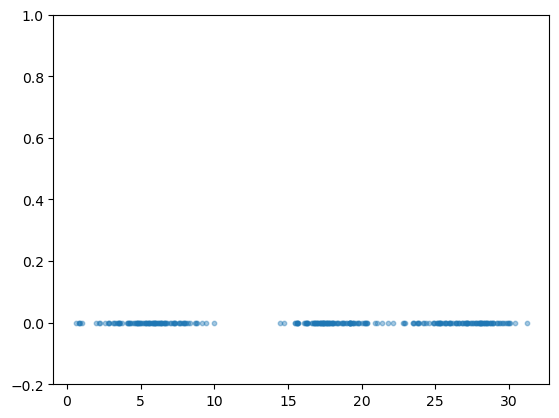

In [55]:
X = gen_data(k=3, dim=1, points_per_cluster=100, lim=[0, 30])
# shuffle the data

np.random.shuffle(X)
plot_data(X)

In [80]:
class IGMN:
    def __init__(self, input_dim, beta, all_adults_criterion, age_min, acc_min, max_components, rank_type, closest_n):
        self.input_dim = input_dim

        # hyperparameters
        self.beta = beta
        self.all_adults_critertion = all_adults_criterion
        self.age_min = age_min
        self.acc_min = acc_min
        self.max_components = max_components
        self.rank = rank_type
        self.closest_n = closest_n

        # components
        self.components = []

    def squared_mahalanobis_distance(self, x, mu, cov):
        sigma_inv = np.linalg.inv(cov)
        diff = x - mu
        d_sq = diff.T @ sigma_inv @ diff
        return d_sq.item()
    
    def pdf(self, x, mu, cov):
        D = self.input_dim
        d_sq = self.squared_mahalanobis_distance(x, mu, cov)
        norm_constant = 1 / np.sqrt((2 * np.pi) ** D * np.linalg.det(cov))
        return norm_constant * np.exp(-0.5 * d_sq)

    def create_new_component(self, x, components):
        mu = x
        acc = 1
        age = 1

        # pi => mixing coefficient 
        # also called: p(j) or p(z_j = 1) 
        # -> probability of selecting component j
        if len(components) > 0:
            p = 1 / (sum([comp['acc'] for comp in components]) + 1)
        else:
            p = 1

        # print("creating new component with p = ", p, " acc = ", acc, " age = ", age)

        sigma_ini = 0.01
        sigma = sigma_ini * np.eye(len(x))

        if not np.all(np.linalg.eigvals(sigma) > 0):
            print("Problem: Sigma is not positive definite - x: ", x, " sigma: ", sigma)
            raise ValueError("Sigma is not positive definite")

        # print("Created new component with mu = ", mu, " sigma = ", sigma, " p = ", p, " acc = ", acc, " age = ", age)

        return {"mu": mu, "sigma": sigma, "p": p, "acc": acc, "age": age}

    

    def filter(self):
        """A component j is removed whenever u_j > u_min and sp_j < sp_min, where u_min and sp_min are user-defined thresholds.

        In that case, also, p(k) must be adjusted for all k in K (with k != j).
        In other words, each component is given some tim eu_min to show its importance to the model in the form of an accumulation of its posterior probability sp_j
        """
        for j, component_j in enumerate(self.components):
            if component_j['age'] > self.age_min and component_j['acc'] < self.acc_min:
                print("Removing component ", j)
                self.components.pop(j)
        
        self.update_priors()

    def update_with_x(self, component_j, x):
        denom = 0
        for comp in self.components:
            p_x_k = self.pdf(x, comp['mu'], comp['sigma'])
            denom += p_x_k * comp['p']

        p_x_j = self.pdf(x, component_j['mu'], component_j['sigma']) # equation 2
        p_j_x = (p_x_j * component_j['p']) / denom # equation 3
        component_j['age'] = component_j['age'] + 1 # equation 4
        component_j['acc'] = component_j['acc'] + p_j_x # equation 5
        e_j = x - component_j['mu'] # equation 6
        omega_j = p_j_x / component_j['acc'] # equation 7
        delta_mu_j = omega_j * e_j # equation 8
        component_j['mu'] = component_j['mu'] + delta_mu_j # equation 9
        e_j2 = x - component_j['mu'] # equation 10

        
        copy = component_j["sigma"].copy()

        # TODO!!!
        # clip delta_mu_j to avoid making the covariance matrix non positive definite
        delta_mu_j = np.clip(delta_mu_j, -0.01, 0.01)

        component_j["sigma"] = \
            (1 - omega_j) * copy \
            + omega_j * (e_j2 @ e_j2.T) \
            - delta_mu_j @ delta_mu_j.T # equation 11
        
        # do not use full rank covariance matrix, only keep variances
        if self.rank == "diag":
            component_j["sigma"] = np.diag(np.diag(component_j["sigma"]))
        
        if not np.all(np.linalg.eigvals(component_j["sigma"]) > 0):
            raise ValueError("Sigma is not positive definite")
        
        component_j['p'] = component_j['acc'] / sum([comp['acc'] for comp in self.components]) # equation 12

    
    def update(self, x):
        if not self.components:
            # print("No components yet, creating new one")
            new_component = self.create_new_component(x, self.components)
            self.components.append(new_component)
            return
        
        chi_sq_threshold = chi2.ppf(1-self.beta, self.input_dim)

        updated = False

        self.filter()

        for j, component_j in enumerate(self.components):

            d_sq = self.squared_mahalanobis_distance(x, 
                                                     component_j['mu'], 
                                                     component_j['sigma']) # equation 1)
            
            # check if d_sq is negative and throw error otherwise
            if d_sq < 0:
                raise ValueError(f"Negative squared Mahalanobis distance: {d_sq} based on x = {x}, mu = {component_j['mu']}, sigma = {component_j['sigma']}")

            if d_sq < chi_sq_threshold:
                self.update_with_x(component_j, x)
                updated = True

        # criterion 2: only create a new neuron if all neurons of that model have an age greater than the parameter age_min
        all_adults = all([comp['age'] > self.age_min for comp in self.components]) if self.all_adults_critertion else True
        
        if not updated and all_adults:
            
            if len(self.components) < self.max_components:
                print("Creating new component for x = ", x)
                new_component = self.create_new_component(x, self.components)
                self.components.append(new_component)
            else:
                print("Merging to closest component for x = ", x)
                self.merge_to_closest_n(x)

        
        self.update_priors()

    def merge_to_closest_n(self, x):
        """
        Merge the new observation to the closest component in the model.
        """
        distances = []
        for component in self.components:
            d_sq = self.squared_mahalanobis_distance(x, 
                                                     component['mu'], 
                                                     component['sigma'])

            distances.append(d_sq)

        # sort the components by distance
        sorted_components = [comp for _, comp in sorted(zip(distances, self.components))]
        closest_components = sorted_components[:self.closest_n]

        for comp in closest_components:
            self.update_with_x(comp, x)


    def update_priors(self):
        total_acc = sum([comp['acc'] for comp in self.components])
        for comp in self.components:
            comp['p'] = comp['acc'] / total_acc

    def predict(self, x, filter_n=None):

        components = self.components
        if filter_n:
            components = sorted(components, key=lambda c: c["p"], reverse=True)[:filter_n].copy()

            total_acc = sum([comp['acc'] for comp in components])
            for comp in components:
                comp['p'] = comp['acc'] / total_acc
        
        prob = 0
        for comp in components:
            p_x_j = self.pdf(x, comp['mu'], comp['sigma'])
            p = comp['p']
            prob += p_x_j * p
        return prob

In [81]:
igmn = IGMN(input_dim=1, beta=0.1, all_adults_criterion=False, age_min=5.0, acc_min=3.0, max_components=10, rank_type = "diag", closest_n=10)
idx = 0
looped = 0

In [84]:
for i in range(2000+1):
    # next sample
    x = X[idx]
    
    # print every 100th iteration
    #if (idx % 100) == 0:
    #    print("Iteration: ", (len(X) * looped) + idx)

    # update the model with new sample
    igmn.update(x)

    # update index
    idx += 1
    # loop again over indices if we reached the end
    if idx == len(X):
        idx = 0
        looped += 1

print("Number of components: ", len(igmn.components))
print("Components centered at: ", [comp['mu'].item() for comp in igmn.components])

Merging to closest component for x =  [4.79049868]
Removing component  3
Removing component  3
Creating new component for x =  [7.58578163]
Creating new component for x =  [8.73683601]
Merging to closest component for x =  [4.1747732]
Removing component  3
Creating new component for x =  [3.55406732]
Merging to closest component for x =  [1.00029694]
Removing component  3
Creating new component for x =  [2.83300232]
Removing component  3
Removing component  4
Creating new component for x =  [4.78923911]
Creating new component for x =  [10.01147019]
Merging to closest component for x =  [0.61665135]
Removing component  3
Removing component  3
Creating new component for x =  [0.81193238]
Creating new component for x =  [9.4226414]
Merging to closest component for x =  [3.21121149]
Merging to closest component for x =  [2.26817005]
Removing component  3
Removing component  3
Creating new component for x =  [3.55044026]
Creating new component for x =  [8.70789898]
Merging to closest compon

IGMN has  10  components
GMM integral:  0.9940134822026073


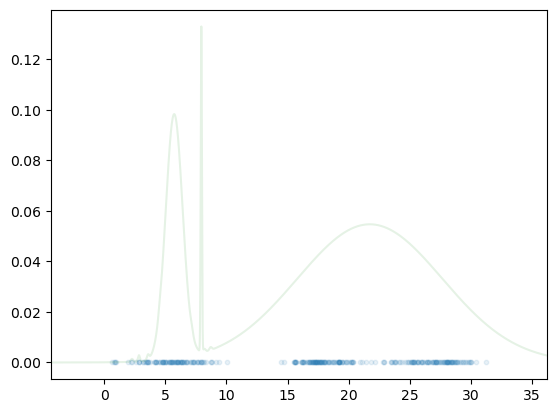

In [85]:
x_min, x_max = min(X)-5, max(X)+5
n_samples = 10000
x, y = predict(igmn, n_samples, x_min, x_max, filter_n=None)

print("IGMN has ", len(igmn.components), " components")
print("GMM integral: ", scipy.integrate.simpson(y, x))
plot_gmm(X, x_min, x_max, x, y)


In [ ]:
# # draw 2d density function for the component with highest p overlayed with the data

# def plot_data(x, igmn):
#     dim = x.shape[1]
#     fig = plt.figure()
#     ax = fig.gca()

#     if (dim == 1):
#         #ax.hist(x, bins=50, alpha=0.7)
#         ax.scatter(x, np.zeros_like(x), s=10, alpha=0.4)
#         # put y lim between 0 and 1
#         ax.set_ylim(-0.2, 1)
#     if(dim == 2):
#         ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
#         ax.autoscale(enable=True)

#     # each component is part of gaussian mixture model, draw the density function
#     # weigth each component by its mixing coefficient p 

#     for component in igmn.components:
#         mu = component['mu']
#         sigma = component['sigma']
#         p = component['p']

#         if dim == 1:
#             x = np.linspace(-1, 35, 100)
#             y = p * np.exp(-0.5 * (x - mu)**2 / sigma)
#             ax.plot(x, y[0], color='red', alpha=0.5)

#     # set max y lim between -0.01 and 0.2
#     ax.set_ylim(-0.01, 0.2)


    
# plot_data(X, igmn)



In [ ]:
# create 

In [ ]:
# # sort components by age
# sorted(igmn.components, key=lambda x: x['age'], reverse=True)[0:10]

# # draw the first 3 components on the plot of the generated data
# fig = plt.figure()
# ax = fig.gca()
# ax.scatter(X[:,0], X[:,1], s=3, alpha=0.4)
# ax.autoscale(enable=True)

# for comp in igmn.components:
#     ax.scatter(comp['mu'][0], comp['mu'][1], s=10, alpha=0.3)


In [ ]:
# x = np.array([ -7.57918632, -12.55769486])
# mu = np.array([-7.10540817, -8.75339249])

# cov = np.eye(2)
# cov = np.array([[-0.00050521, -0.0055289 ],
#                  [-0.0055289,  -0.00050521]])

# print(sqrt(igmn.squared_mahalanobis_distance(x, mu, cov)))

# from scipy.spatial import distance
# print(distance.mahalanobis(x, mu, np.linalg.inv(cov)))

In [ ]:
# for component in igmn.components:
#     print("Component mean:", component['mu'])
#     print("Component covariance matrix:", component['sigma'])
#     print("Component prior probability:", component['p'])


In [ ]:
# def is_pos_def(x):
#     return np.all(np.linalg.eigvals(x) > 0)

# def is_symmetric(x):
#     return np.all(x-x.T==0)

# # check if the covariance matrix is positive definite
# cov = np.array([[-4.78534862e-05, -5.04785349e-03],
#                 [-5.04785349e-03, -4.78534862e-05]])



# print(is_pos_def(cov), is_symmetric(cov))


# print(np.linalg.det(cov))